## CrowdED: Crowdsourcing task optimization
---
The research question we aim to answer is: "Can we a-priori estimate optimal workers and tasks' assignment to obtain maximum accuracy on all tasks?"

*This notebook takes step by step the construction of the crowdED module*

In [36]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---
### Data preparation: Tasks and Workers Dataframe Construction

I want to model the workers

In [2]:
total_tasks = 342

In [3]:
total_workers = 50

In [4]:
#Tasks variables
p_hard_tasks = 0.2
n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))

p_easy_tasks = 1-p_hard_tasks 
n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))

In [5]:
print(n_hard_tasks, n_easy_tasks)

68 274


#### Workers

In [6]:
workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]

In [7]:
df_workers = pd.DataFrame()
df_workers['worker_id'] = workers

In [8]:
df_workers.head()

,worker_id
0,Y9tD8
1,89Rdh
2,WY5cp
3,8YafN
4,G7dHR


Next, we randomly assign (without [replacement](https://www.ma.utexas.edu/users/parker/sampling/repl.htm)) which tasks easy/hard based on the proportions specified.

#### Tasks 

In [9]:
tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]
easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]
hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

#### True Answers (Gold)

In our simulation, the task is that the worker has to choose one out of the five given answers. Here, we simulate the true answer for each worker-task pair.

In [10]:
#answers_key = ["liver", "blood", "lung", "brain", "heart"]
from random_words import RandomWords
rw = RandomWords()
answers_key = rw.random_words(count=5)

In [11]:
answers_key

['background', 'petition', 'pond', 'torque', 'porter']

It is needed one of the keys for the answer

In [12]:
true_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]

In [13]:
# Creating the tasks data frame
df_tasks = pd.DataFrame()
df_tasks['task_id'] = tasks
df_tasks['true_answers'] = true_answers

In [14]:
df_tasks['label_task'] = ['hard_task' if tasks[i] in hard_tasks else 'easy_task' for i in range(total_tasks)]

In [15]:
df_tasks.head()

,task_id,true_answers,label_task
0,task_S4i,pond,easy_task
1,task_gCx,porter,hard_task
2,task_ueh,torque,easy_task
3,task_g6x,background,easy_task
4,task_NoG,petition,easy_task


---
### Probabilities of getting the answer right
In this step, we first calculate the exact probabilities of getting the answer right for each worker and each task.

Since the ability is unknown before the task is undertaken, we use a beta distribution to model the distribution of worker ability. Its probability density function $f(x|a, v)$ is given by 

$$
f(x|a,v) = Beta (\frac{a}{\min(a,1-a)v}, \frac{(1-a)}{\min(a,1-a)v})
$$

Here a ∈ (0, 1) is the normalized value of the average ability of the workers in the crowdsourcing platform.  
v ∈ (0, 1) is a parameter that determines the variance in worker ability  
[Paper](https://aaai.org/ocs/index.php/HCOMP/HCOMP16/paper/viewFile/14047/13632)  

Mean probability 0.9101219169369827


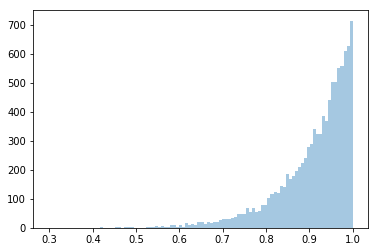

In [45]:
from scipy.stats import beta
data_beta = beta.rvs(10, 1, size=10000)
sns.distplot(data_beta, kde=False, bins=100)
print('Mean probability {}'.format(np.mean(data_beta)))

In general we have good workers, on average the 90% of chances to getting the answer right

In [46]:
df_workers['prob_worker'] = beta.rvs(10, 1, size=total_workers)

In [47]:
df_workers.head()

,worker_id,prob_worker
0,Y9tD8,0.989541
1,89Rdh,0.968505
2,WY5cp,0.976443
3,8YafN,0.962569
4,G7dHR,0.980576


In [49]:
# Threshold of responses
cut_tasks = 0.75
probs_tasks = []
for i in df_tasks['label_task']:
    if i == 'easy_task': #uniform from .75 to 1
        probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
    elif i == 'hard_task': #uniform from .5 to .75
        probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
    else: probs_tasks.append(1)

probs_tasks = [item for prob in probs_tasks for item in prob]

In [51]:
df_tasks['prob_task'] = probs_tasks

In [52]:
df_tasks.head()

,task_id,true_answers,label_task,prob_task
0,task_S4i,pond,easy_task,0.80
1,task_gCx,porter,hard_task,0.70
2,task_ueh,torque,easy_task,0.87
3,task_g6x,background,easy_task,0.88
4,task_NoG,petition,easy_task,0.93


#### Summary of aggregated probabilities

In [53]:
df_tasks.groupby('label_task').agg(['mean','count'])

prob_task      
                mean count
label_task                
easy_task   0.869600   275
hard_task   0.605075    67

In [55]:
df_workers.describe()

,prob_worker
count,50.000000
mean,0.902522
std,0.094719
min,0.593422
25%,0.863804
50%,0.930864
75%,0.976018
max,0.999520


--- 
Lets not split the 2 faces, just make everything in one run

In [56]:
workers_per_task = 5

In [57]:
list_tasks = [[tasks[i]]*workers_per_task for i in range(total_tasks)] #replicate the tasks to train 
list_tasks = [item for sublist in list_tasks for item in sublist] #flat and clean list

In [58]:
# Asign workers on every task 
tasks_workers = [np.random.choice(workers, workers_per_task, replace=False) for task in tasks]
tasks_workers = [worker for sublist in tasks_workers for worker in sublist] #flat and clean list

In [59]:
df_tw = pd.DataFrame()
df_tw['task_id'] = list_tasks
df_tw['worker_id'] = tasks_workers

In [60]:
workers_agg = df_tw.groupby('worker_id').agg('count')

In [61]:
# REVIEW THIS, HOW DO WE MAKE SURE ALL THE WORKERS HAVE TASK ASIGNATED
workers_agg.sort_values('task_id', ascending=False).head()

,task_id
worker_id,
fvMNg,47
tBiHM,46
Qx8ac,44
9LpDB,43
m2QA6,42


In [65]:
df_tw = pd.merge(df_tw, df_tasks, on='task_id', how='left')
df_tw = pd.merge(df_tw, df_workers, on='worker_id', how='left')

In [66]:
prob_guess = 1 / len(answers_key)

w = worker answer correct  
T = Having knowledge to do the task


$$
P(w~|~T) = \frac{P(T~|~w) P(w)}{P(T~|~w) P(w) + P(T~|~w^c) P(w^c)}
$$

[Bayes for conditional probability example](http://www.stat.yale.edu/Courses/1997-98/101/condprob.htm)

In [67]:
df_tw['prob_answer'] = (df_tw['prob_task'] * df_tw['prob_worker']) / (df_tw['prob_task'] * df_tw['prob_worker'] + prob_guess * (1-df_tw['prob_worker']))

The Bernoulli is the posterior function to modelate the action

In [69]:
from scipy.stats import bernoulli
worker_prediction = [bernoulli.rvs(size=1,p=prob)[0] for prob in df_tw['prob_answer']]

In [99]:
#sns.distplot(worker_prediction, kde=False, color="skyblue")

In [79]:
df_tw['prediction'] = worker_prediction

In [75]:
worker_answers = []
for idx, i in enumerate(worker_prediction):
    if i == 1:
        worker_answers.append(df_tw['true_answers'].loc[idx])
    else:
        worker_answers.append(np.random.choice([i for i in set(answers_key)-set(df_tw['true_answers'].loc[idx])], 1)[0])

In [76]:
df_tw['worker_answers'] = worker_answers

In [81]:
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker,prob_answer,worker_answers,prediction
0,task_S4i,m2QA6,pond,easy_task,0.8,0.993378,0.998336,pond,1
1,task_S4i,WY5cp,pond,easy_task,0.8,0.976443,0.994005,pond,1
2,task_S4i,wjbQr,pond,easy_task,0.8,0.873294,0.964997,pond,1
3,task_S4i,9LpDB,pond,easy_task,0.8,0.861381,0.961324,pond,1
4,task_S4i,R4GmE,pond,easy_task,0.8,0.977995,0.994407,pond,1


---
### Confusion Matrix for the answers

In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_tw['true_answers'], df_tw['worker_answers'])

array([[331,   6,   3,   3,   2],
       [  3, 261,   0,   2,   4],
       [  0,   2, 411,   0,   2],
       [  2,   2,   2, 293,   1],
       [  2,   3,   3,   1, 391]])

In [83]:
import turicreate as tc
sf_tw = tc.SFrame(data=df_tw)
conf_matrix = tc.evaluation.confusion_matrix(sf_tw['true_answers'], sf_tw['worker_answers'])

In [84]:
conf_matrix.print_rows(25,)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|  background  |    background   |  331  |
|    torque    |       pond      |   3   |
|    porter    |    background   |   2   |
|   petition   |    background   |   3   |
|    torque    |      porter     |   1   |
|     pond     |      torque     |   2   |
|   petition   |     petition    |  261  |
|  background  |       pond      |   3   |
|   petition   |      torque     |   4   |
|     pond     |     petition    |   2   |
|   petition   |      porter     |   2   |
|    torque    |     petition    |   3   |
|    porter    |      torque     |   1   |
|    porter    |     petition    |   2   |
|  background  |      torque     |   2   |
|    porter    |      porter     |  293  |
|  background  |     petition    |   6   |
|    torque    |    background   |   2   |
|    torque    |      torque     |  391  |
|    porter    |       pond      |   2   |
|     pond 

In [85]:
accuracy = conf_matrix[conf_matrix['target_label'] == conf_matrix['predicted_label']]['count'].sum() / conf_matrix['count'].sum()

In [86]:
print(accuracy)

0.9751445086705203


Try the confusion matrix library to track all the different measures of the workers  
https://github.com/sepandhaghighi/pycm

---
### Measuring Performance

Next we measure the performance of the worker. The performance is calculate as the number of times a worker answers right (in comparison with the true answer) over the total number of workers per task.  

The range of the performance value spans from 0 to 1. The values close to 1 indicate that the majority of the workers had consensus. The values close to 0 indicate that there was no consensus.

In [87]:
df_tw['performance'] = worker_prediction

In [102]:
#tasks_mean = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)
#tasks_mean['performance'].head()

Prediction Correct 1674 of 1730


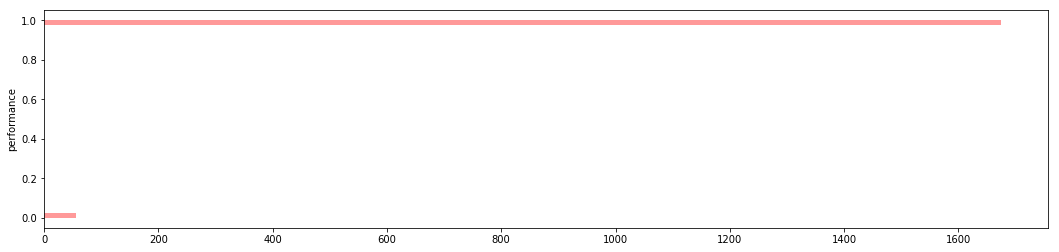

In [106]:
#Distribution of the performance
plt.figure(figsize=[18, 4])
sns.distplot(df_tw['performance'], kde=False, vertical=True, color="red")
print('Prediction Correct {} of {}'.format(df_tw['performance'].sum(), df_tw['performance'].count()))

In [107]:
workers_mean = df_tw.groupby('worker_id').mean().sort_values('performance', ascending=False)
df_workers = pd.merge(workers_mean.reset_index(), df_workers.drop('prob_worker',1), on='worker_id', how='left')

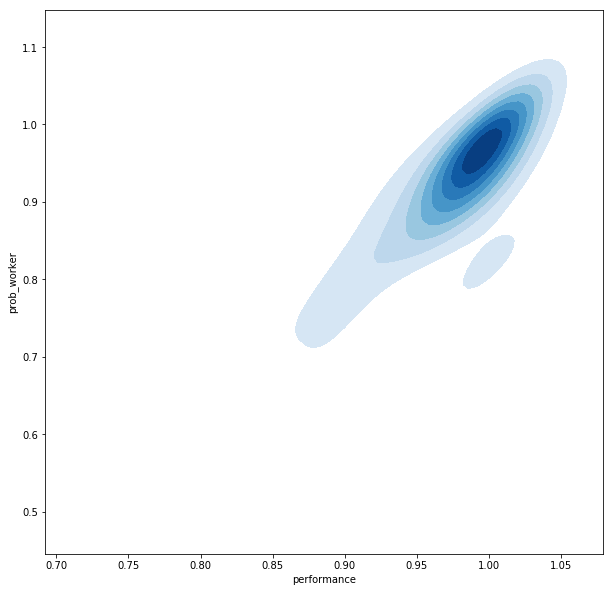

In [108]:
plt.figure(figsize=[10, 10])
sns.kdeplot(df_workers['performance'], df_workers['prob_worker'], cmap="Blues", shade=True, shade_lowest=False)

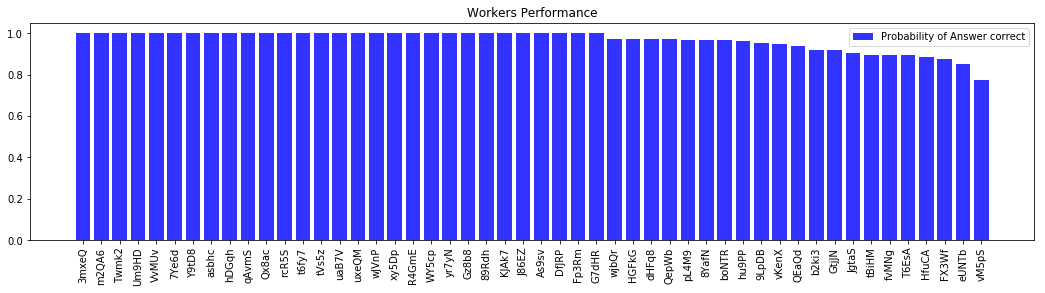

In [109]:
plt.figure(figsize=[18, 4])
axis = range(len(workers_mean))
plt.bar(axis, workers_mean['performance'], align='center', alpha=0.8, color='blue', label='Probability of Answer correct')
plt.xticks(axis, workers_mean.index, rotation=90)
plt.title('Workers Performance')
plt.legend(loc='best')
plt.show()

In [179]:
df_workers.describe()

,prob_task,prob_worker,prob_answer,prediction,performance
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.822869,0.855898,0.956411,0.957301,0.957301
std,0.017243,0.107422,0.036806,0.054136,0.054136
min,0.782581,0.565647,0.837622,0.800000,0.800000
25%,0.808661,0.806900,0.943871,0.941597,0.941597
50%,0.820645,0.848094,0.957281,0.971008,0.971008
75%,0.834342,0.954616,0.988095,1.000000,1.000000
max,0.872143,0.996468,0.999128,1.000000,1.000000


--- 
## Split the good workers from the rest  

Take all the workers whose performance was complete (1)

In [110]:
worker_label = []
for i in df_workers['performance']:
    if i == 1:
        worker_label.append('good_worker')
    else:
        worker_label.append('poor_worker')
        
df_workers['label_worker'] = worker_label

In [112]:
#f_workers

---
# Accuracy One Function

In [113]:
total_tasks = 342
total_workers = 50
p_hard_tasks = 0.2
n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))
p_easy_tasks = 1-p_hard_tasks 
n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))
print(n_hard_tasks, n_easy_tasks)

68 274


In [114]:
param_beta1 = 10
param_beta2 = 1

In [115]:
workers_per_task = 5

In [1]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
from random_words import RandomWords
from scipy.stats import beta
from scipy.stats import bernoulli
from sklearn.metrics import confusion_matrix
import turicreate as tc

def get_accuracy(total_tasks, total_workers, p_hard_tasks, workers_per_task, param_beta1 = 1, param_beta2 = 1):
    workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]
    df_workers = pd.DataFrame()
    df_workers['worker_id'] = workers
    #### Tasks 
    tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]
    easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]
    hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

    rw = RandomWords()
    answers_key = rw.random_words(count=5)
    true_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]

    # Creating the tasks data frame
    df_tasks = pd.DataFrame()
    df_tasks['task_id'] = tasks
    df_tasks['true_answers'] = true_answers
    df_tasks['label_task'] = ['hard_task' if tasks[i] in hard_tasks else 'easy_task' for i in range(total_tasks)]

    data_beta = beta.rvs(param_beta1, param_beta2, size=total_workers)
    df_workers['prob_worker'] = data_beta #probs_workers

    # Threshold of responses
    cut_tasks = 0.75
    probs_tasks = []
    for i in df_tasks['label_task']:
        if i == 'easy_task':
            probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
        elif i == 'hard_task':
            probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
        else: probs_tasks.append(1)

    probs_tasks = [item for prob in probs_tasks for item in prob]
    df_tasks['prob_task'] = probs_tasks

    list_tasks = [[tasks[i]]*workers_per_task for i in range(total_tasks)] #replicate the tasks to train 
    list_tasks = [item for sublist in list_tasks for item in sublist] #flat and clean list

    # Asign workers on every task 
    tasks_workers = [np.random.choice(workers, workers_per_task, replace=False) for task in tasks]
    tasks_workers = [worker for sublist in tasks_workers for worker in sublist] #flat and clean list

    df_tw = pd.DataFrame()
    df_tw['task_id'] = list_tasks
    df_tw['worker_id'] = tasks_workers
    df_tw = pd.merge(df_tw, df_tasks, on='task_id', how='left')
    df_tw = pd.merge(df_tw, df_workers, on='worker_id', how='left')

    prob_guess = 1 / len(answers_key)
    df_tw['prob_answer'] = (df_tw['prob_task'] * df_tw['prob_worker']) / (df_tw['prob_task'] * df_tw['prob_worker'] + prob_guess * (1-df_tw['prob_worker']))

    worker_prediction = [bernoulli.rvs(size=1,p=prob)[0] for prob in df_tw['prob_answer']]

    worker_answers = []
    for idx, i in enumerate(worker_prediction):
        if i == 1:
            worker_answers.append(df_tw['true_answers'].loc[idx])
        else:
            worker_answers.append(np.random.choice([i for i in set(answers_key)-set(df_tw['true_answers'].loc[idx])], 1)[0])

    df_tw['worker_answers'] = worker_answers
    df_tw['performance'] = worker_prediction


    confusion_matrix(df_tw['true_answers'], df_tw['worker_answers'])


    sf_tw = tc.SFrame(data=df_tw)
    conf_matrix = tc.evaluation.confusion_matrix(sf_tw['true_answers'], sf_tw['worker_answers'])
    accuracy = conf_matrix[conf_matrix['target_label'] == conf_matrix['predicted_label']]['count'].sum() / conf_matrix['count'].sum()
    
    return accuracy, df_tw

/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [117]:
accuracy = get_accuracy(total_tasks, total_workers, p_hard_tasks, workers_per_task, param_beta1, param_beta2)[0]
accuracy

0.9865497076023392

In [121]:
vec_workers = [i+10 for i in range(1000)] #[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

In [122]:
accu = [get_accuracy(total_tasks, i, p_hard_tasks, workers_per_task, param_beta1, param_beta2) for i in vec_workers]

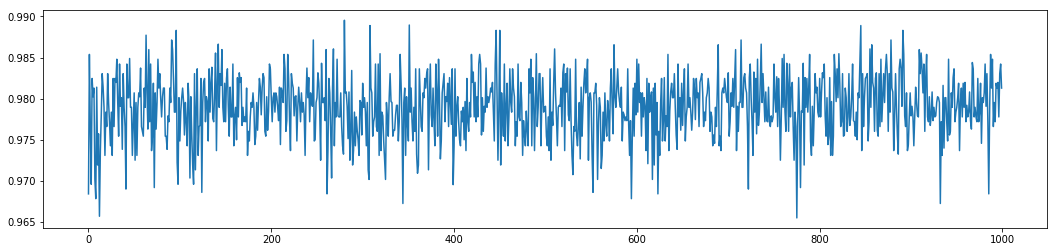

In [123]:
plt.figure(figsize=[18, 4])
plt.plot(range(len(vec_workers)), accu)

---

## 2 Stages

In [2]:
p_train_tasks = .3

In [4]:
total_tasks = 342
total_workers = 50
p_hard_tasks = 0.2
n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))
p_easy_tasks = 1-p_hard_tasks 
n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))
print(n_hard_tasks, n_easy_tasks)

68 274


In [5]:
tasks_to_train = int(p_train_tasks*total_tasks)
tasks_to_train

102

In [6]:
param_beta1 = 10
param_beta2 = 1

In [7]:
workers_per_task = 5

In [9]:
# From the entire set of tasks, randomly choose p_train_tasks (in this case 40) tasks to train.
#training_tasks = np.random.choice(tasks, tasks_to_train, replace=False)
#training_tasks

1. Class for the tasks construction
2. Class for the workers construction
3. Joint Dataset construction
4. Predict answers

In [ ]:
accu = [get_accuracy(total_tasks, i, p_hard_tasks, workers_per_task, param_beta1, param_beta2) for i in vec_workers]

To compare the 2 stages against no training split:  
    is needed to make the process without split
    then take a part of the tasks 30% and do the process, and select the best workers
    then with the 70% left assess with the good workers
    
(the difference between this aproach and the version 1 is that we do not know the workker probability a priori 